In [1]:
import numpy as np
import time

from triqs.gf import *
from triqs.gf.meshes import MeshDLRImFreq
from triqs_tprf.lattice import inv

from itertools import product
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from gwsolver import GWSolver
from exact_diag import exact_diag, ed_occupation, ed_mu
from pino import exact_g, analytical_g

from hubbard import GWHubbardDimer


matplotlib.rcParams.update({'font.size': 22})

Starting serial run at: 2024-03-08 15:37:22.130580


In [15]:
def plot(a, b, spin = 'up'):
    orbitals = len(a[spin].data[0, 0, :])
    fig, axs = plt.subplots(orbitals, orbitals, figsize = (10 * orbitals, 10 * orbitals), facecolor = 'black')
    spin = 'up'


    for i in range(orbitals):
        for j in range(orbitals):
            axs[i, j].set_facecolor('black')
            axs[i, j].xaxis.label.set_color('white')
            axs[i, j].tick_params(axis = 'x', colors = 'white')
            axs[i, j].yaxis.label.set_color('white')
            axs[i, j].tick_params(axis = 'y', colors = 'white')
            axs[i, j].set_xlim(-5, 5)
            # axs[i, j].xaxis.label.set_fontsize(20)

            axs[i, j].scatter([w.imag for w in a.mesh.values()], a[spin].data[:, i, j].real, color = 'blue', zorder = 1, s = 20)
            axs[i, j].scatter([w.imag for w in a.mesh.values()], a[spin].data[:, i, j].imag, color = 'red', zorder = 1, s = 20)

            axs[i, j].plot([w.imag for w in b.mesh.values()], b[spin].data[:, i, j].real, color = 'white', zorder = 0)
            axs[i, j].plot([w.imag for w in b.mesh.values()], b[spin].data[:, i, j].imag, color = 'white', zorder = 0)

def symmetric_difference(omega, value, A):
    w_index = np.argmin(np.abs(omega - value))

    left_sum = np.sum(A[:w_index])
    right_sum = np.sum(A[w_index:])
    return left_sum - right_sum

def find_center_freq(g):
    omega = np.array([w for w in g.mesh.values()])
    A = spectral(g)

    w_step = 5.0

    w = 0
    difference = symmetric_difference(omega, w, A)
    last_difference = 2 * difference

    previous_direction = None
    iter = 0
    while abs(difference) > 0.0001:
        if abs(difference - last_difference) < 1e-6:
            break

        iter += 1
        if difference < 0:
            if previous_direction == 'decrement':
                w_step /= 2
            previous_direction = 'increment'
            w += w_step
        else:
            if previous_direction == 'increment':
                w_step /= 2
            previous_direction = 'decrement'
            w -= w_step

        last_difference = difference
        difference = symmetric_difference(omega, w, A)
    
    return w

def offset(g_w, w, w_center_arg):
    return np.argmin(np.abs(w - find_center_freq(g_w))) - w_center_arg

def spectral(g_w):
    A = 0
    for name, g in g_w:
        A += -np.imag(np.trace(g.data[:, :, :], axis1 = 1, axis2 = 2))
    return A

def generate_g0_w(tij, mesh, spin_names = ['up', 'dn']):
    g_inv = Gf(mesh = mesh, target_shape = np.shape(tij))
    g_inv << iOmega_n - tij.transpose()
    g = inv(g_inv, 8)
    return BlockGf(block_list = [g] * 2, name_list = spin_names, make_copies = False)

def coulomb_matrix(orbitals, U, non_local = True):
    Vij = np.zeros([orbitals] * 2)
    for i in range(orbitals):
        for j in range(orbitals):
            Vij[i, j] = round(0.75 * U / (abs(i - j) + 1), 2)

        Vij[i, i] = U
    if non_local:
        return Vij

    return np.diag(Vij.diagonal())

def coulomb_tensor(orbitals, U, non_local = True):
    Vij = coulomb_matrix(orbitals, U, non_local)
    Vijkl = np.zeros([orbitals] * 4)
    for i in range(orbitals):
        for j in range(orbitals):
            Vijkl[i, j, i, j] = Vij[i, j]
    return Vijkl

def spectral(g_w):
    A = 0
    for name, g in g_w:
        A += -np.imag(np.trace(g.data[:, :, :], axis1 = 1, axis2 = 2))
    return A

def N(g_w):
    return g_w.total_density().real

def GWtoED(orbitals, N_fix, t, U, beta = 20, max_iter = 1, non_local = False, pade = False):

    def rel_error(ed, g):
        size = len(list(g.mesh.values()))
        errors = np.zeros((size, orbitals, orbitals)) * 1j
        for i, w in enumerate(g.mesh):
            ed = ED['up'](w)
            g_up = g['up'].data[i, :, :]
            errors[i] = (ed - g_up) / ed

        return 100 * np.max(np.abs(errors))

    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = -t
        tij[i + 1, i] = -t

    Vij = coulomb_matrix(orbitals, U, non_local = non_local)
    Vijkl = coulomb_tensor(orbitals , U, non_local = non_local)

    iw_mesh_f = MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 20.0, eps = 1e-12, symmetrize = True)
    g0_w = generate_g0_w(tij, iw_mesh_f)

    ED, mu_ed = exact_diag(tij, Vijkl, N_fix, beta = beta, nw = 1024)

    gw = GWSolver(g0_w, Vij, self_interactions = False, hartree_flag = True, fock_flag = True, mu = 0, N_fix = N_fix, max_iter = max_iter, full_mesh = False)
    
    print(f'g0_w occupation: {round(N(gw.g0_w), 5)}, Chemical potential: {gw.mu0}')
    print(f'g_w occupation: {round(N(gw.g_w), 5)}, Chemical potential: {gw.mu}')
    print(f'ED occupation: {round(N(ED), 5)}, Chemical potential: {mu_ed}')
    print(f'Max rel. error: {round(rel_error(ED, gw.g_w), 2)}%')
    print(f'Iteration reached: {gw.iter_reached}')
    # print(N(ED))
    # print(gw.mu)
    if not pade:
        plot(gw.g_w, ED)
        return

    w_mesh = MeshReFreq(window = (-15, 15), n_w = 1 * 2048)
    w = np.array([W for W in w_mesh.values()])

    w_min = -5
    w_max = -w_min

    w_min_arg = np.argmin(np.abs(w - w_min))
    w_max_arg = np.argmin(np.abs(w - w_max))
    w_center_arg = np.argmin(np.abs(w))


    G_w_temp = Gf(mesh = w_mesh, target_shape = [orbitals, orbitals])
    G_w = BlockGf(block_list = [G_w_temp] * 2, name_list = ['up', 'dn'])
    for block, g in G_w:
        G_w[block].set_from_pade(ED[block], n_points = 100, freq_offset = 0.1)

    g_w_temp = Gf(mesh = w_mesh, target_shape = [orbitals, orbitals])
    g_w = BlockGf(block_list = [g_w_temp] * 2, name_list = ['up', 'dn'])
    for block, g in G_w:
        g_w[block].set_from_pade(gw.g_w[block], n_points = 100, freq_offset = 0.1)


    G_w_offset = offset(G_w, w, w_center_arg)

    fig, ax = plt.subplots(1, figsize = (12, 12), facecolor = 'black')
    ax.xaxis.label.set_fontsize(20)
    ax.set_facecolor('black')
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis = 'x', colors = 'white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis = 'y', colors = 'white')
    ax.set_xlim(w_min, w_max)

    ax.plot([w for w in G_w.mesh.values()][w_min_arg:w_max_arg], spectral(G_w)[w_min_arg + G_w_offset:w_max_arg + G_w_offset], color = 'white', zorder = 0)
    ax.scatter([w for w in g_w.mesh.values()][w_min_arg:w_max_arg], spectral(g_w)[w_min_arg + G_w_offset:w_max_arg + G_w_offset], color = 'red', s = 3, zorder = 1)
    plt.show()
    return

def relativeErrors(orbitals, N_fix, t, U, beta = 20, max_iter = 1, non_local = False):

    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = -t
        tij[i + 1, i] = -t

    Vij = coulomb_matrix(orbitals, U, non_local = non_local)
    Vijkl = coulomb_tensor(orbitals , U, non_local = non_local)

    iw_mesh_f = MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 20.0, eps = 1e-12, symmetrize = True)
    g0_w = generate_g0_w(tij, iw_mesh_f)
    gw = GWSolver(g0_w, Vij, self_interactions = False, hartree_flag = True, fock_flag = True, mu = 0, N_fix = N_fix, max_iter = max_iter, full_mesh = False)
    ED, mu = exact_diag(tij, Vijkl, N_fix, beta = beta, nw = 1024)

    size = len(list(iw_mesh_f.values()))
    errors = np.zeros((size, orbitals, orbitals)) * 1j

    for i, w in enumerate(iw_mesh_f):
        ed = ED['up'](w)
        g = gw.g_w['up'].data[i, :, :]

        errors[i] = (ed - g) / ed


    fig, axs = plt.subplots(orbitals, orbitals, figsize = (7 * orbitals, 7 * orbitals), facecolor = 'black')
    s = 15
    
    for i in range(orbitals):
        for j in range(orbitals):
            axs[i, j].set_facecolor('black')
            axs[i, j].xaxis.label.set_color('white')
            axs[i, j].tick_params(axis = 'x', colors = 'white')
            axs[i, j].yaxis.label.set_color('white')
            axs[i, j].tick_params(axis = 'y', colors = 'white')
            axs[i, j].set_xlim(-5, 5)
            # axs[i, j].set_ylim(-5, 5)


            axs[i, j].scatter([w.imag for w in iw_mesh_f.values()], 100 * errors[:, i, j].real, color = 'red', zorder = 0, s = s)
            axs[i, j].scatter([w.imag for w in iw_mesh_f.values()], 100 * errors[:, i, j].imag, color = 'blue', zorder = 0, s = s)
    return

def interactions(orbitals, N_fix, beta = 20, max_iter = 1, non_local = False):
    t = 1.0
    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = -t
        tij[i + 1, i] = -t



    iw_mesh_f = MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 20.0, eps = 1e-12, symmetrize = True)
    g0_w = generate_g0_w(tij, iw_mesh_f)

    U_list = np.arange(0, 1.8, 0.3)

    fig, axs = plt.subplots(1, len(U_list), figsize = (len(U_list) * 10, 10), facecolor = 'black')

    for i, U in enumerate(U_list):
        Vij = coulomb_matrix(orbitals, U, non_local = non_local)
        Vijkl = coulomb_tensor(orbitals , U, non_local = non_local)

        ED, mu_ed = exact_diag(tij, Vijkl, N_fix, beta = beta, nw = 1024)

        gw = GWSolver(g0_w, Vij, self_interactions = False, hartree_flag = True, fock_flag = True, mu = 0, N_fix = N_fix, max_iter = max_iter, full_mesh = True)
        
        


        axs[i].set_facecolor('black')
        axs[i].xaxis.label.set_color('white')
        axs[i].tick_params(axis = 'x', colors = 'white')
        axs[i].yaxis.label.set_color('white')
        axs[i].tick_params(axis = 'y', colors = 'white')
        axs[i].set_xlim(-5, 5)


        axs[i].scatter([w.imag for w in gw.g_w.mesh.values()], spectral(gw.g_w), color = 'red', zorder = 1, s = 20)


        axs[i].plot([w.imag for w in ED.mesh.values()], spectral(ED), color = 'white', zorder = 0)


def colorPlot(orbitals, N_fix, t, non_local = True, beta = 100, max_iter = 1):
    
    def pade(g, mesh, orbitals):
        g_w_temp = Gf(mesh = mesh, target_shape = [orbitals, orbitals])
        g_w = BlockGf(block_list = [g_w_temp] * 2, name_list = ['up', 'dn'])
        for block, gg in g_w:
            g_w[block].set_from_pade(g[block], n_points = 100, freq_offset = 0.1)
        return g_w
    
    def spectral_offset(g, w, w_center_arg):
        g_offset = 0 * offset(g, w, w_center_arg)
        return spectral(g)[w_min_arg + g_offset:w_max_arg + g_offset]
    
    
    Agw = []
    Aed = []

    iw_mesh_f = MeshDLRImFreq(beta = beta, statistic = 'Fermion', w_max = 20.0, eps = 1e-12, symmetrize = True)
    w_mesh = MeshReFreq(window = (-15, 15), n_w = 1 * 2048)

    w = np.array([W for W in w_mesh.values()])

    w_min = -5
    w_max = -w_min

    w_min_arg = np.argmin(np.abs(w - w_min))
    w_max_arg = np.argmin(np.abs(w - w_max))
    w_center_arg = np.argmin(np.abs(w))


    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = -t
        tij[i + 1, i] = -t

    g0_w = generate_g0_w(tij, iw_mesh_f)

    U_list = np.linspace(0, 1.5, 32) * t
    for U in U_list:
        Vij = coulomb_matrix(orbitals, U, non_local = non_local)
        Vijkl = coulomb_tensor(orbitals , U, non_local = non_local)

        gw = GWSolver(g0_w, Vij, self_interactions = False, hartree_flag = True, fock_flag = True, N_fix = N_fix, max_iter = max_iter, full_mesh = True)
        g_iw = gw.g_w
        g_w = pade(g_iw, w_mesh, orbitals)
        G_iw = exact_diag(tij, Vijkl, N_fix, beta = beta, nw = 1 * 1024)
        G_w = pade(G_iw, w_mesh, orbitals)

        Aed.append(spectral_offset(G_w, w, w_center_arg))
        Agw.append(spectral_offset(g_w, w, w_center_arg))

    fig, axs = plt.subplots(1, 2, figsize = (20, 10), facecolor = 'black')
    axs[0].imshow(np.transpose(Aed), cmap='viridis', aspect='auto', norm=LogNorm(vmin=0.01, vmax=np.max(Aed)))
    axs[1].imshow(np.transpose(Agw), cmap='viridis', aspect='auto', norm=LogNorm(vmin=0.01, vmax=np.max(Agw)))

    for i in range(2):
        axs[i].set_facecolor('black')
        axs[i].xaxis.label.set_color('white')
        axs[i].tick_params(axis = 'x', colors = 'white')
        axs[i].yaxis.label.set_color('white')
        axs[i].tick_params(axis = 'y', colors = 'white')

        x_range = np.linspace(0, len(U_list), 10)
        axs[i].set_xticks(x_range)
        axs[i].set_xticklabels(np.round(np.linspace(0, np.max(U_list), len(x_range)), 1), fontsize = 15)
        axs[i].set_xlabel("U", fontsize = 20)

    axs[0].set_ylabel("omega", fontsize = 20)
    axs[1].set_yticks([])
    y_range = np.linspace(0, w_max_arg - w_min_arg, 11)
    axs[0].set_yticks(y_range)
    axs[0].set_yticklabels(np.round(np.array([w[w_min_arg + int(i)] for i in y_range]), 1), fontsize = 15)

    axs[0].set_title("E.D.", color = 'white', fontsize = 25)
    axs[1].set_title("GW", color = 'white', fontsize = 25)

    plt.show()

    return

def occupation(orbitals, N_fix, t, U, beta, max_iter, N_tol, non_local = False):

    def dyson(g, mu):
        return (g.inverse() - mu).inverse()
    
    def occ(g, mu):
        return dyson(g, mu).total_density().real
    

    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = -t
        tij[i + 1, i] = -t

    Vij = coulomb_matrix(orbitals, U, non_local = non_local)
    Vijkl = coulomb_tensor(orbitals, U, non_local = non_local)

    
    mu_list = np.linspace(-orbitals * t, orbitals * t, 50)
    occ_list_gw = np.zeros_like(mu_list)
    occ_list_g0 = np.zeros_like(mu_list)
    occ_list_ed = np.zeros_like(mu_list)
    for i, mu in enumerate(mu_list):
        print(f'Index {i + 1}/{len(mu_list)}', end = '\r')
        gw = GWSolver(generate_g0_w(tij, MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 20.0, eps = 1e-12, symmetrize = True)), Vij,\
            self_interactions = False, hartree_flag = True, fock_flag = True, mu = mu, N_fix = False, N_tol = N_tol, max_iter = max_iter, full_mesh = False, verbose = False)
        
        occ_list_gw[i] = gw.g_w.total_density().real
        occ_list_g0[i] = gw.g0_w.total_density().real

        occ_list_ed[i] = ed_occupation(tij, Vijkl, beta, mu)
    print('\n')
    fig, ax = plt.subplots(1, figsize = (20, 20), facecolor = 'black')
    ax.xaxis.label.set_fontsize(20)
    ax.set_facecolor('black')
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis = 'x', colors = 'white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis = 'y', colors = 'white')

    ax.plot(mu_list, occ_list_gw, color = 'red', lw = 4, label = 'gw', zorder = 1)
    ax.plot(mu_list, occ_list_g0, color = 'blue', lw = 4, label = 'g0', zorder = 1)
    ax.plot(mu_list, occ_list_ed, color = 'green', lw = 4, label = 'ED', zorder = 1)
    ax.legend(fontsize = 25)
    ax.set_xlabel('Chemical Potential')
    ax.set_ylabel('Occupation')
    if N_fix is not False:
        gw = GWSolver(generate_g0_w(tij, MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 20.0, eps = 1e-12, symmetrize = True)), Vij,\
            self_interactions = False, hartree_flag = True, fock_flag = True, mu = 0, N_fix = N_fix, N_tol = N_tol, max_iter = max_iter, full_mesh = False)
        # print(gw.mu, gw.N(gw.g_w))

        ax.scatter(gw.mu0, gw.g_w.total_density().real, color = 'white', zorder = 2, s = 100)
        ax.scatter(gw.mu0, gw.g0_w.total_density().real, color = 'white', zorder = 2, s = 100)
        found_mu_ed, occ_ed = ed_mu(tij, Vijkl, beta, N_fix, N_tol)
        ax.scatter(found_mu_ed, occ_ed, color = 'white', zorder = 2, s = 100)
        
    ax.grid(zorder = 0)
    ax.set_axisbelow(True)
    plt.show()

    return

def analytical(U):
    orbitals = 2
    t = 1.0

    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = -t
        tij[i + 1, i] = -t

    Vij = coulomb_matrix(orbitals, U, non_local = False)

    beta = 100

    iw_mesh_f = MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 5.0, eps = 1e-12, symmetrize = True)
    g0_w = generate_g0_w(tij, iw_mesh_f)

    gw = GWSolver(g0_w, Vij, self_interactions = True, hartree_flag = True, fock_flag = True, full_mesh = True)
    G = exact_g(iw_mesh_f, t, U)
    plot(gw.g_w, G)

def errors(orbitals, N_fix, beta = 100, max_iter = 25, non_local = False):
    t = 1.0
    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = -t
        tij[i + 1, i] = -t

    iw_mesh_f = MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 20.0, eps = 1e-12, symmetrize = True)
    g0_w = generate_g0_w(tij, iw_mesh_f)

    real = []
    imag = []

    os = []
    sc = []

    U_list = np.linspace(0, 1.2, 10)
    for U in U_list:
        Vij = coulomb_matrix(orbitals, U, non_local = non_local)
        Vijkl = coulomb_tensor(orbitals , U, non_local = non_local)
        gw = GWSolver(g0_w, Vij, self_interactions = False, hartree_flag = True, fock_flag = True, mu = 0, N_fix = N_fix, max_iter = 2, full_mesh = False)
        gw_oneshot = GWSolver(g0_w, Vij, self_interactions = False, hartree_flag = True, fock_flag = True, mu = 0, N_fix = N_fix, max_iter = 1, full_mesh = False)
        ED, mu = exact_diag(tij, Vijkl, N_fix, beta = beta, nw = 1024)
        size = len(list(iw_mesh_f.values()))
        errors = np.zeros((size, orbitals, orbitals)) * 1j
        errors_os = np.zeros((size, orbitals, orbitals)) * 1j

        for i, w in enumerate(iw_mesh_f):
            ed = ED['up'](w)
            g = gw.g_w['up'].data[i, :, :]
            g_os = gw_oneshot.g_w['up'].data[i, :, :]

            errors[i] = (ed - g) / ed
            errors_os[i] = (ed - g_os) / ed


        sc.append(100 * np.max(np.abs(errors)))

        os.append(100 * np.max(np.abs(errors_os.real)))
        
    fig, ax = plt.subplots(figsize = (24, 16), facecolor = 'black')
    s = 15
    ax.set_facecolor('black')
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis = 'x', colors = 'white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis = 'y', colors = 'white')

    lw = 3

    ax.plot(U_list, sc, marker = 'o', color = 'red', label = 'self-consistent', lw = lw)
    ax.plot(U_list, os, marker = 'o', color = 'blue', label = 'One-shot', lw = lw)

    ax.set_ylim(0, 10)
    ax.set_xlabel('U/t')
    ax.set_ylabel('Max relative error (%)')
    ax.legend()
    ax.grid()
    plt.show()

    return

def errors2(orbitals, N_fix, beta = 100, max_iter = 10, non_local = False):
    def rel_error(ed, g):
        size = len(list(g.mesh.values()))
        errors = np.zeros((size, orbitals, orbitals)) * 1j
        for i, w in enumerate(g.mesh):
            ed = ED['up'](w)
            g_up = g['up'].data[i, :, :]
            errors[i] = (ed - g_up) / ed

        return 100 * np.max(np.abs(errors))
 
    t = 1.0
    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = -t
        tij[i + 1, i] = -t

    iw_mesh_f = MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 20.0, eps = 1e-12, symmetrize = True)
    g0_w = generate_g0_w(tij, iw_mesh_f)

    U_list = np.linspace(0, 1.5, 25)
    errors_list = []
    for j, U in enumerate(U_list):
        Vij = coulomb_matrix(orbitals, U, non_local = non_local)
        Vijkl = coulomb_tensor(orbitals , U, non_local = non_local)

        errors = []
        ED, mu = exact_diag(tij, Vijkl, N_fix, beta = beta, nw = 1024)
        for i in range(1, max_iter + 2):
            gw = GWSolver(g0_w, Vij, self_interactions = False, hartree_flag = True, fock_flag = True, mu = 0, N_fix = N_fix, max_iter = i, full_mesh = False)

            errors.append(rel_error(ED, gw.g_w))
        errors_list.append(errors)

    errors_list = np.array(errors_list).transpose()
    fig, ax = plt.subplots(figsize = (24, 16), facecolor = 'black')
    s = 15
    ax.set_facecolor('black')
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis = 'x', colors = 'white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis = 'y', colors = 'white')

    lw = 3

    for i in range(len(errors_list)):
        if i == 0:
            ax.plot(U_list, errors_list[i, :], marker = 'o', label = f'One-shot', lw = lw)
        elif i == 1:
            ax.plot(U_list, errors_list[i, :], marker = 'o', label = f'1 iteration', lw = lw)
        else:
            ax.plot(U_list, errors_list[i, :], marker = 'o', label = f'{i} iterations', lw = lw)

    ax.set_ylim(0, 15)
    ax.set_xlabel('U/t')
    ax.set_ylabel('Max relative error (%)')
    ax.legend()
    ax.grid()
    plt.show()


    return


Iteration 1/1



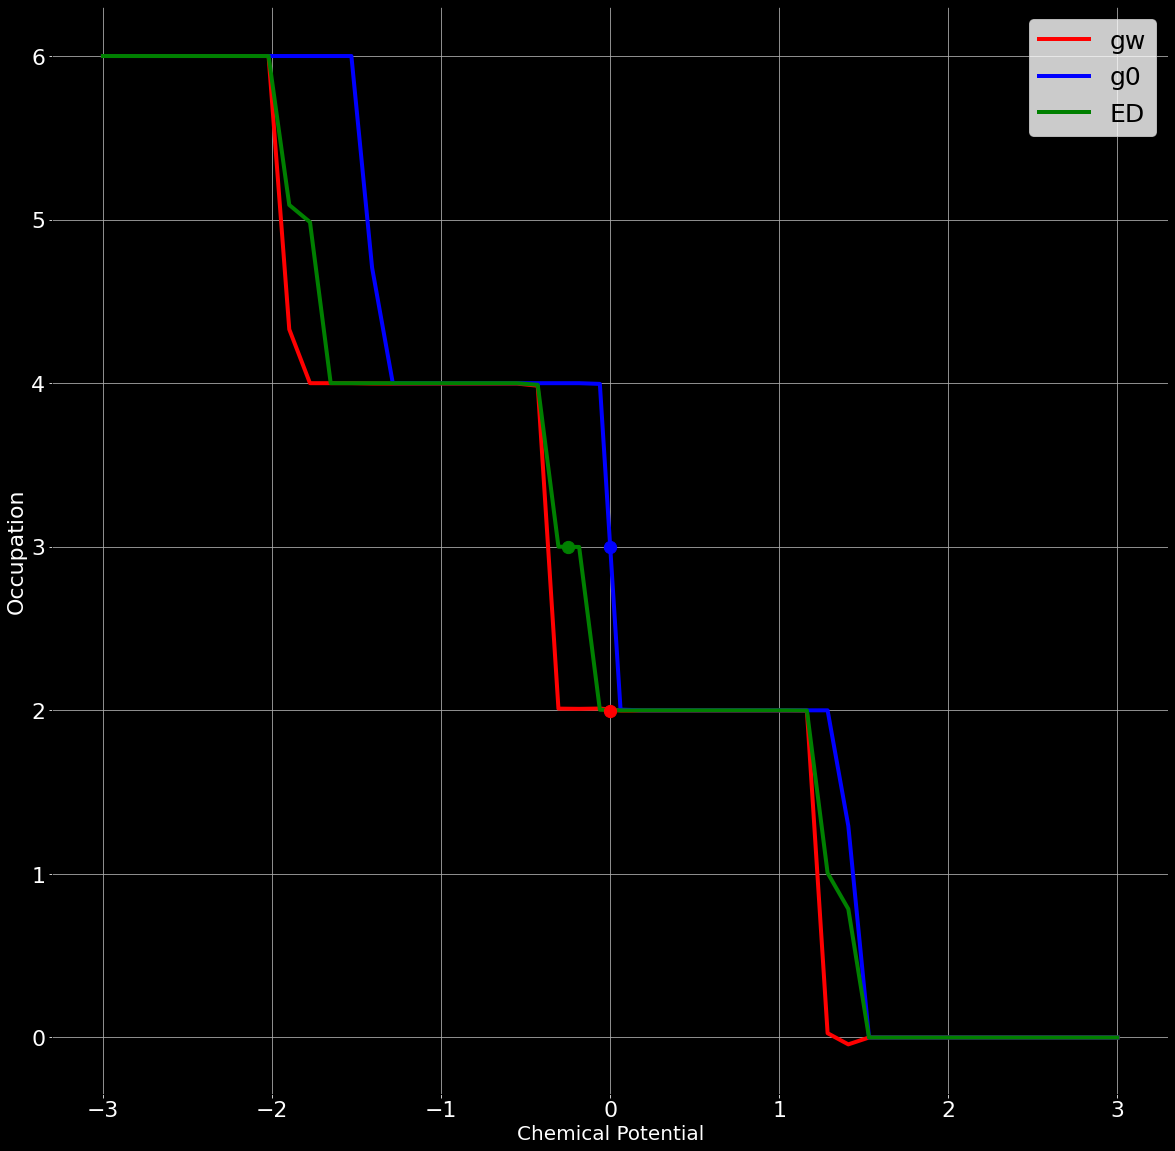

In [16]:
occupation(orbitals = 3, N_fix = 3, t = 1.0, U = 0.5, beta = 100, max_iter = 1, N_tol = 1e-3, non_local = False)

In [4]:
# interactions(orbitals = 4, N_fix = False, beta = 100, max_iter = 1)

In [5]:
# errors(orbitals = 2, N_fix = False, beta = 100, max_iter = 5, non_local = False)

In [6]:
# errors2(orbitals = 2, N_fix = False, beta = 100, max_iter = 5, non_local = False)

In [7]:
# GWtoED(orbitals = 2, N_fix = False, t = 1.0, U = 2.05, beta = 100, max_iter = 1000)